### It seems that `sbi` always gives conditional posterior $P(\theta|x)$. Try to build our own NDE, not conditioned on anything

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn, Tensor, optim
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import os
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, StandardScaler

In [4]:
from nflows import flows, transforms
from nflows.nn import nets
from nflows import distributions as distributions_

from sbi.utils.sbiutils import standardizing_transform

In [5]:
## Load the NN emulator `speculator`
with open('./best_loss_model.pkl', 'rb') as f:
    speculator = pickle.load(f)

In [6]:
flag = np.array([ True,  True,  True,  True,  True, False,  True,  True, False])
zero_flag = (np.mean(np.load('./train_sed/log_spec_all.npy'), axis=1) < -30)
log_spec_all = np.load('./train_sed/log_spec_all.npy')[~zero_flag]
params = np.load('./train_sed/param_all.npy')[:, ~flag][~zero_flag]

In [7]:
y_test = np.random.multivariate_normal(mean=[6, -0.5], cov=[[2, 1], [1, 0.2]], size=2000)
y_test = Tensor(y_test)
x_test = speculator.predict_spec(y_test)

In [8]:
# x_train = torch.Tensor(params[np.random.randint(0, 100, 20)])

In [12]:
def build_maf(
    batch_x: Tensor = None,
    z_score_x: bool = True,
    hidden_features: int = 50,
    num_transforms: int = 5,
    embedding_net: nn.Module = nn.Identity(),
    **kwargs,
) -> nn.Module:
    """Builds MAF p(x|y).
    Args:
        batch_x: Batch of xs, used to infer dimensionality and (optional) z-scoring.
        z_score_x: Whether to z-score xs passing into the network.
        hidden_features: Number of hidden features.
        num_transforms: Number of transforms.
        embedding_net: Optional embedding network for y.
        kwargs: Additional arguments that are passed by the build function but are not
            relevant for maf and are therefore ignored.
    Returns:
        Neural network.
    """
    x_numel = batch_x[0].numel()

    if x_numel == 1:
        warn(f"In one-dimensional output space, this flow is limited to Gaussians")

    transform = transforms.CompositeTransform(
        [
            transforms.CompositeTransform(
                [
                    transforms.MaskedAffineAutoregressiveTransform(
                        features=x_numel,
                        hidden_features=hidden_features,
                        num_blocks=2,
                        use_residual_blocks=False,
                        random_mask=False,
                        activation=torch.tanh,
                        dropout_probability=0.0,
                        use_batch_norm=True,
                    ),
                    transforms.RandomPermutation(features=x_numel),
                ]
            )
            for _ in range(num_transforms)
        ]
    )

#     if z_score_x:
#         transform_zx = standardizing_transform(batch_x)
#         transform = transforms.CompositeTransform([transform_zx, transform])
        
    distribution = distributions_.StandardNormal((x_numel,))
    neural_net = flows.Flow(transform, distribution, embedding_net).to('cuda')

    return neural_net

In [16]:
samples

tensor([[  6.9318,   3.0731],
        [ -1.1493,   9.6757],
        [ 17.7814,   2.3005],
        ...,
        [ -7.1897,  -5.0614],
        [-11.2282, -12.4207],
        [  0.9606,  -1.2659]], device='cuda:0', grad_fn=<DivBackward0>)

In [18]:
maf = build_maf(y_test)
optimizer = optim.Adam(maf.parameters())
samples = maf.sample(5000, batch_size=None)
_coeff = speculator.predict(samples)#.cpu().detach().numpy()

In [154]:
num_iter = 5000

for i in range(num_iter):
    optimizer.zero_grad()
    loss = ???????????
    loss.backward()
    optimizer.step()

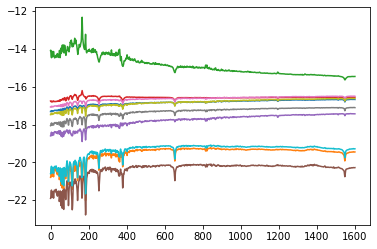

In [17]:
plt.plot(_spec.cpu().detach().numpy().T)

In [63]:
samples = maf.sample(10000,).detach().numpy()

 In order to get the distribution of theta using an ensemble of spectra, the neural density estimator should estimate the posterior conditioned on an ensemble of spectra, not on a single spectrum. But I didn't figure out how to do this using `sbi`.

In [166]:
## Test the NDE for a single spectrum, generally looks good

In [167]:
flag = np.array([ True,  True,  True,  True,  True, False,  True,  True, False])
zero_flag = (np.mean(np.load('./train_sed/log_spec_all.npy'), axis=1) < -30)
log_spec_all = np.load('./train_sed/log_spec_all.npy')[~zero_flag]
params = np.load('./train_sed/param_all.npy')[:, ~flag][~zero_flag]

In [168]:
ind = 333
x_o = log_spec_all[ind]

In [169]:
samples = posterior.sample((10000,), x=x_o).detach().numpy()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [57]:
y_test = np.random.multivariate_normal(mean=[6, -0.5], cov=[[2, 1], [1, 0.2]], size=2000)

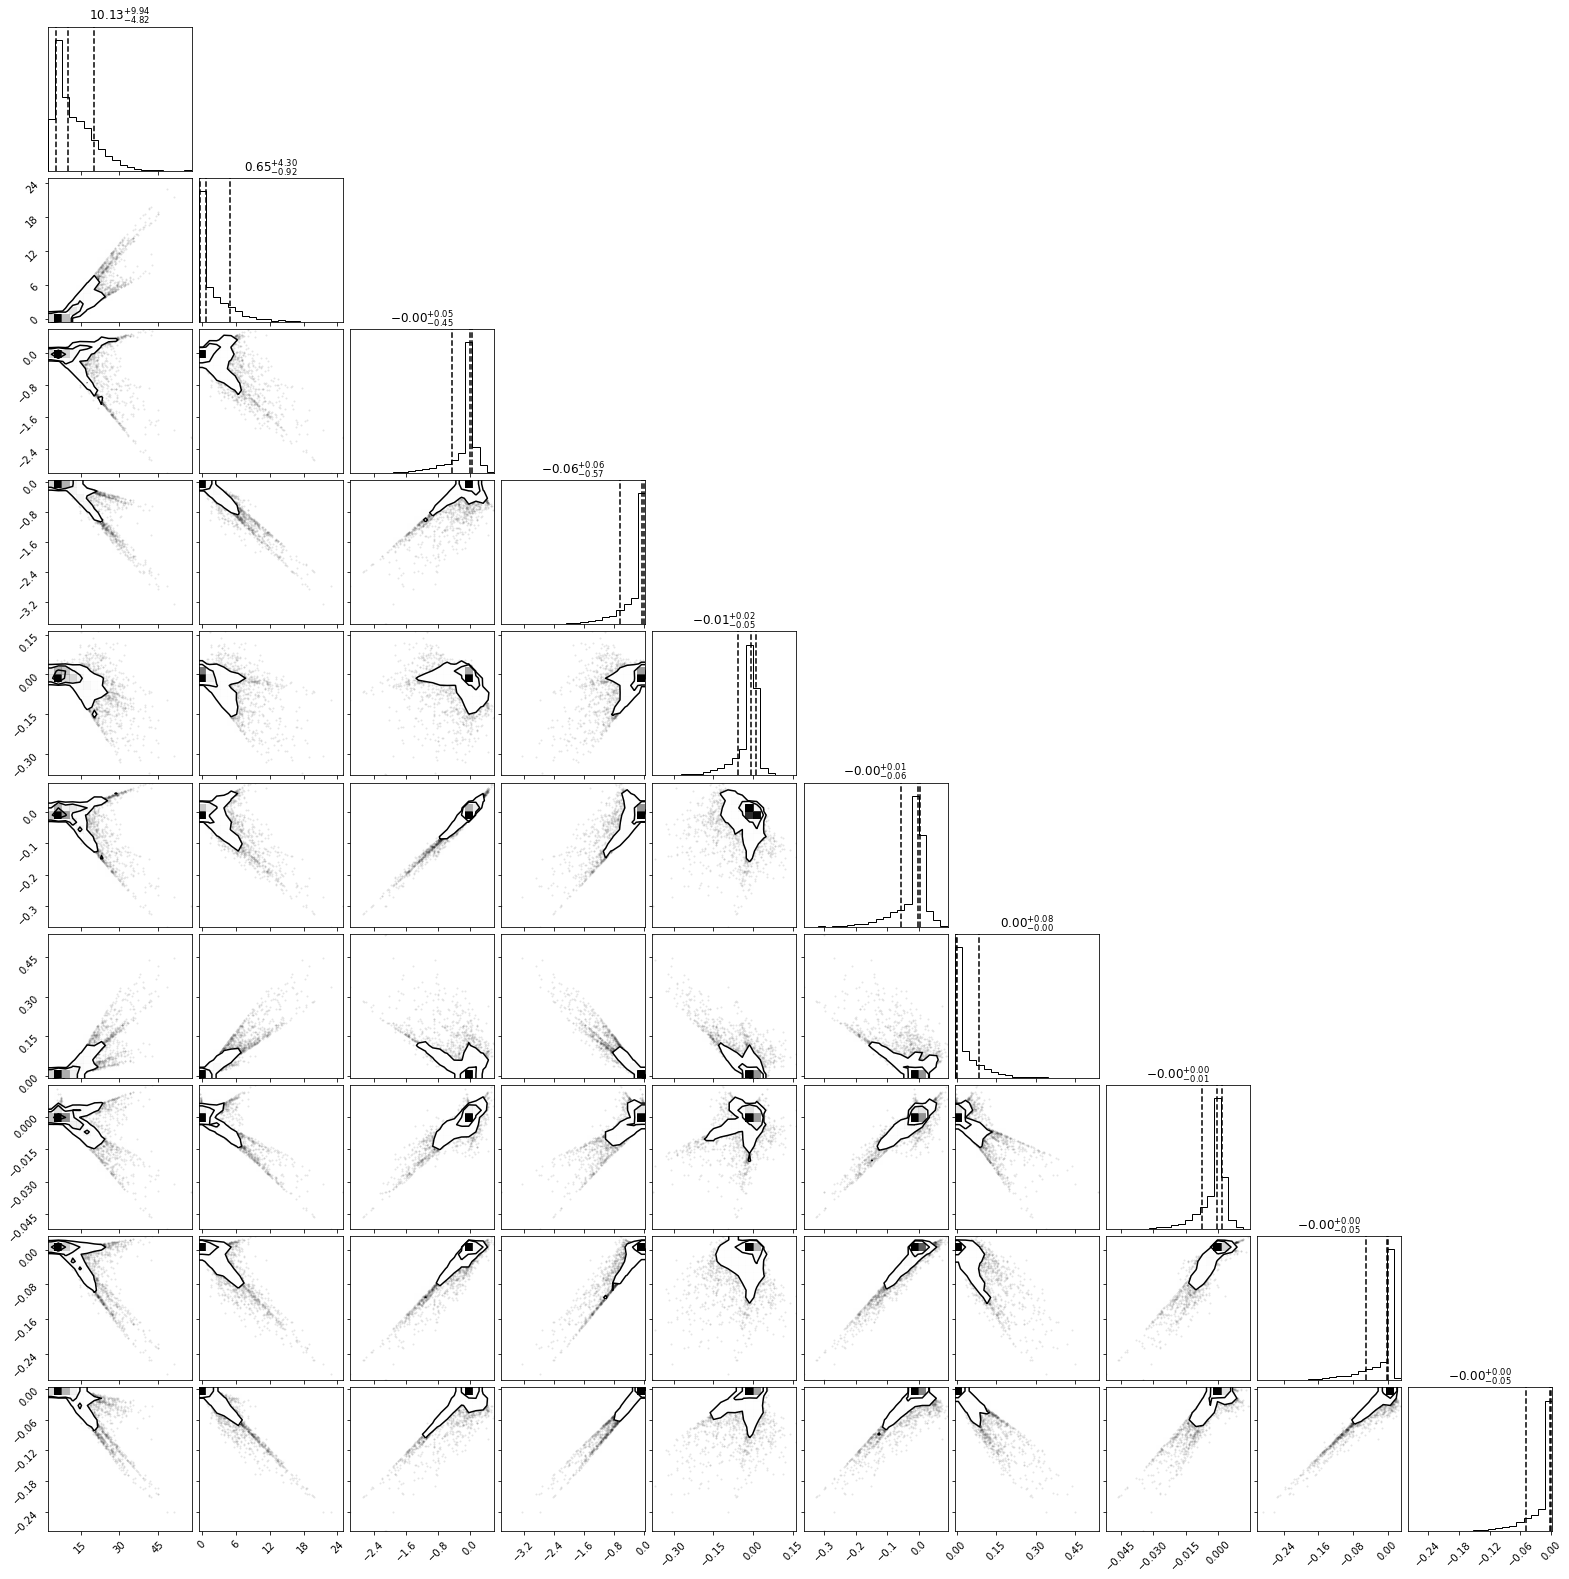

In [156]:
import corner

figure = corner.corner(_coeff.cpu().detach().numpy(), quantiles=[0.16, 0.5, 0.84], #labels=['tage', 'tau'],
                       show_titles=True, title_kwargs={"fontsize": 12})

#corner.overplot_lines(figure, params[ind], color="C1")
#corner.overplot_points(figure, params[ind][None], marker="s", color="C1")